In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout
from sklearn.preprocessing import StandardScaler
from keras.layers import Flatten

In [7]:
# Step 1: Dataset Yukleme
file_path = '/kaggle/input/ttc4900/7allV03.csv'
df = pd.read_csv(file_path)

# Step 2: Veri On Isleme
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['category'], test_size=0.2, random_state=42
)
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Step 3: Word2Vec ile Tokenizasyon ve Kelime Gomme
preprocessed_data = [text_to_word_sequence(text) for text in train_data]
word2vec_model = Word2Vec(sentences=preprocessed_data, vector_size=128, window=5, min_count=1, workers=4)
word_index = {word: index for index, word in enumerate(word2vec_model.wv.index_to_key)}


# Sozlukteki her kelime icin Word2Vec yerlestirmelerini yazdirma
max_words_to_display = 1  
for word, index in word_index.items():
    if index < max_words_to_display:
        try:
            embedding_vector = word2vec_model.wv[word]
            print(f"Word: {word}, Embedding: {embedding_vector}")
        except KeyError:
            print(f"Word: {word} not found in Word2Vec embeddings.")


train_sequences_word2vec = [[word_index[word] for word in text_to_word_sequence(text) if word in word_index] for text in train_data]
test_sequences_word2vec = [[word_index[word] for word in text_to_word_sequence(text) if word in word_index] for text in test_data]

max_length = 100
train_padded_word2vec = pad_sequences(train_sequences_word2vec, maxlen=max_length, truncating='post')
test_padded_word2vec = pad_sequences(test_sequences_word2vec, maxlen=max_length, truncating='post')

# Step 4: Word2Vec ve Model Mimarinizle Sinir Agini Olusturma ve Egitme
embedding_matrix = word2vec_model.wv.vectors
embedding_layer = Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_matrix.shape[1], input_length=max_length, weights=[embedding_matrix], trainable=False)

# Flatten the embedded sequences
flatten_layer = Flatten()

# Dense layers
dense_layer1 = Dense(128, activation='relu')
dropout_layer1 = Dropout(0.5)
dense_layer2 = Dense(64, activation='relu')
dropout_layer2 = Dropout(0.5)

# Output layer
output_layer = Dense(7, activation='softmax')

# Modeli olusturma
model_ann = Sequential([
    embedding_layer,
    flatten_layer,
    dense_layer1,
    dropout_layer1,
    dense_layer2,
    dropout_layer2,
    output_layer
])

# Modeli Derleme
model_ann.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Modeli Egitme
model_ann.fit(train_padded_word2vec, train_labels_encoded, epochs=10, validation_data=(test_padded_word2vec, test_labels_encoded))

# Modeli degerlendirme
test_loss, test_acc = model_ann.evaluate(test_padded_word2vec, test_labels_encoded)
print(f'Test Accuracy: {test_acc}')

Word: ve, Embedding: [ 0.9893578  -0.03989712  1.1970206   0.13399026 -0.6115884  -1.2424878
  0.03143608  0.12258601 -0.82285607  0.15450226  0.75935733  0.23417056
 -0.6817626  -0.07123511 -0.32514814  0.1403823  -1.7018167   0.8259911
 -1.1361123  -0.77319044  1.3749033   1.293142    0.42866337 -0.6108794
 -0.39888385  1.174042   -1.3819036  -0.5250954   1.3807203   0.7913203
 -2.112167   -0.20839712  0.28183693 -0.08958869  1.0882655   1.0242774
  1.1965292   0.8392958   0.22644895 -0.88252604 -0.0786854   0.5218406
 -0.85887706  0.33243027  0.6273476   0.39732572 -0.5991513  -0.12701999
  0.7365151   0.5884833  -0.87442774  0.1825188  -0.68122196  1.102494
  0.63590354 -0.8771411   0.5558754  -0.1349206  -1.1272172   0.1135971
 -1.18561    -0.6532587   0.7492567  -0.9873581   0.9064656  -0.2353052
  0.06318131  0.7272507   0.16828693 -0.7595607  -0.93888414  0.02863525
 -1.2532213  -1.518617    0.0445618   0.52898484 -0.07235653 -0.05356427
 -0.38512248 -0.8397689  -1.2585386   0.

In [9]:
# Modeli Kaydetme
model_ann.save("/kaggle/working/my_word2vec_model")
# Modeli Yukleme
from keras.models import load_model
loaded_model_word2vec = load_model("/kaggle/working/my_word2vec_model")

In [12]:
# Tokenize and pad new input data
new_text = [
    """
    Ön tarafında 6,82 inç büyüklüğünde QHD+ OLED ekran taşıyan OnePlus 12, bu ekranda 120Hz yenileme hızı sunuyor. Ekranın hemen üzerinde 32 Megapiksellik bir selfie kamerası taşıyan cihaz, arka tarafta ana kamera olarak 50 Megapiksellik Sony LYT-808 sensörü kullanıyor. Bu kameranın yanında ise 64 Megapiksel OmniVision OV64B telefoto kamera ve 48 Megapiksel  Sony IMX581 ultra geniş açılı kamera yer alıyor.
    Gücünü Snapdragon 8 Gen 3 yonga setinden alan OnePlus 12, 16 GB ve 24 GB LPDDR5X RAM bellekler ile gücüne güç katıyor. Depolama tarafında 1 TB kapasite sunan amiral gemisi, Android 14 işletim sistemi ile çalışıyor. Elektriksel anlamda gücünü ise 100W kablolu, 50W kablosuz hızlı şarj destekli 5400 mAh‘lik bataryasından alıyor.

Çin’de dört versiyonla satışa sunulan OnePlus 12, 605 Dolar, 680 Dolar, 750 Dolar ve 820 Dolar fiyat etiketleri ile karşımıza çıkmıştı. Ancak cihazın küresel fiyatı ne kadar olacak belli değil. Bakalım OnePlus yeni amiral gemisi modelini küresel pazarda ne kadara satacak?
    """
]

new_sequences_word2vec = [[word_index[word] for word in text_to_word_sequence(text) if word in word_index] for text in new_text]
new_padded_word2vec = pad_sequences(new_sequences_word2vec, maxlen=max_length, truncating='post')

# Make predictions
predictions_word2vec = model_ann.predict(new_padded_word2vec)

# The predictions are probabilities for each class
# You can use numpy.argmax to get the index of the class with the highest probability
predicted_class_word2vec = label_encoder.classes_[predictions_word2vec.argmax(axis=-1)[0]]

print(f"The predicted class is: {predicted_class_word2vec}")

1/1 [==============================] - 0s 19ms/step
The predicted class is: kultur 


In [15]:
import feedparser
import re
import numpy as np
from bs4 import BeautifulSoup
from unidecode import unidecode
import pandas as pd

# Metni temizleme ve on isleme fonksiyonu
def preprocess_text(text):
    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text(separator=' ')

    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Convert to lowercase
    text = text.lower()
    # Convert Turkish characters to ASCII
    text = unidecode(text)
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespaces
    text = ' '.join(text.split())
    return text

def tokenize_and_pad(text, word_index, max_length):
    sequence = [word_index[word] for word in text_to_word_sequence(text) if word in word_index]
    padded_sequence = pad_sequences([sequence], maxlen=max_length, truncating='post')
    return padded_sequence

# URL'yi girme
rss_feed_url = 'https://www.ntv.com.tr/son-dakika.rss'

# Parse the RSS feed
feed = feedparser.parse(rss_feed_url)

# Icerigi ayiklama ve on isleme
contents = [preprocess_text(entry.content[0].value) for entry in feed.entries]

# Tokenlestirme ve pad sequences
sequences = [tokenize_and_pad(content, word_index, max_length) for content in contents if content]

# Herhangi bir dizinin mevcut olup olmadigini kontrol etme
if not sequences:
    print("No valid sequences found. Please check your data.")

# Dizilerin uzunluklarini yazdirma
for i, seq in enumerate(sequences, 1):
    print(f"Sequence {i} Length: {len(seq[0])}")

# Yüklenen modeli kullanarak tahminler yapma
predictions = loaded_model_word2vec.predict(np.vstack(sequences))

# Decode predictions
decoded_predictions = label_encoder.inverse_transform(np.argmax(predictions, axis=1))

# Icerik ve tahminlerle bir DataFrame olusturma
output_data = {'Haber': contents, 'Kategorizasyon': decoded_predictions}
output_df = pd.DataFrame(output_data)

# DataFrame'i bir CSV dosyasina kaydetme
output_csv_path = '/kaggle/working/output_predictions01.csv'  # Specify the desired path
output_df.to_csv(output_csv_path, index=False,sep=';')

# CSV dosya yolunu belirten bir mesaj yazdirma
print(f'Output saved to CSV: {output_csv_path}')


Sequence 1 Length: 100
Sequence 2 Length: 100
Sequence 3 Length: 100
Sequence 4 Length: 100
Sequence 5 Length: 100
Sequence 6 Length: 100
Sequence 7 Length: 100
Sequence 8 Length: 100
Sequence 9 Length: 100
Sequence 10 Length: 100
Sequence 11 Length: 100
Sequence 12 Length: 100
Sequence 13 Length: 100
Sequence 14 Length: 100
Sequence 15 Length: 100
Sequence 16 Length: 100
Sequence 17 Length: 100
Sequence 18 Length: 100
Sequence 19 Length: 100
Sequence 20 Length: 100
Sequence 21 Length: 100
Sequence 22 Length: 100
Sequence 23 Length: 100
Sequence 24 Length: 100
Sequence 25 Length: 100
Sequence 26 Length: 100
Sequence 27 Length: 100
Sequence 28 Length: 100
Sequence 29 Length: 100
Sequence 30 Length: 100
Sequence 31 Length: 100
Sequence 32 Length: 100
Sequence 33 Length: 100
Sequence 34 Length: 100
Sequence 35 Length: 100
Sequence 36 Length: 100
Sequence 37 Length: 100
Sequence 38 Length: 100
Sequence 39 Length: 100
Sequence 40 Length: 100
Sequence 41 Length: 100
Sequence 42 Length: 100
S

31/31 [==============================] - 0s 4ms/step


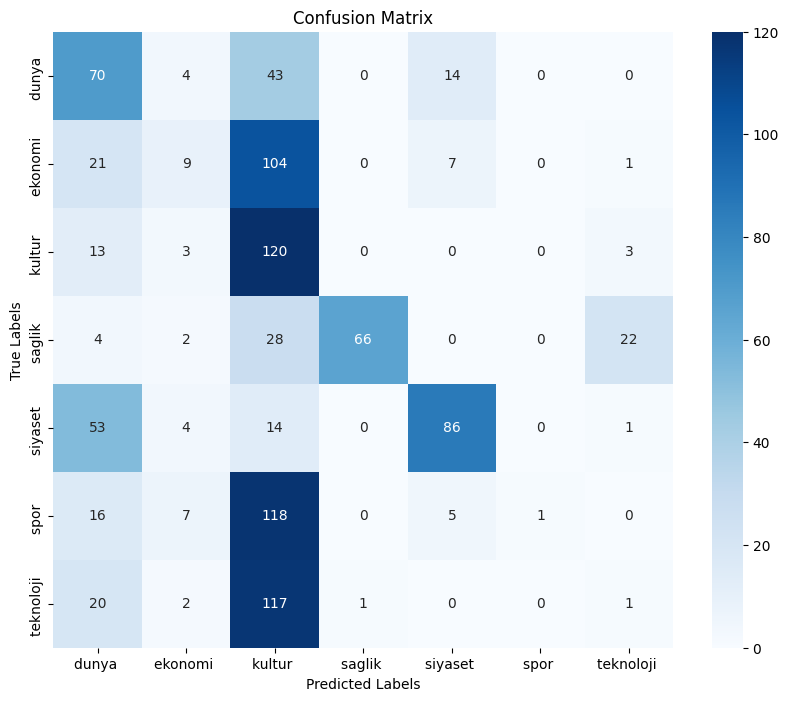

              precision    recall  f1-score   support

      dunya        0.36      0.53      0.43       131
    ekonomi        0.29      0.06      0.10       142
     kultur        0.22      0.86      0.35       139
     saglik        0.99      0.54      0.70       122
    siyaset        0.77      0.54      0.64       158
       spor        1.00      0.01      0.01       147
  teknoloji        0.04      0.01      0.01       141

    accuracy                           0.36       980
   macro avg       0.52      0.37      0.32       980
weighted avg       0.52      0.36      0.32       980



In [16]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions using the loaded model
predictions = loaded_model_word2vec.predict(test_padded_word2vec)
predicted_labels = np.argmax(predictions, axis=1)

# Inverse transform the encoded labels
predicted_labels_original = label_encoder.inverse_transform(predicted_labels)
true_labels_original = label_encoder.inverse_transform(test_labels_encoded)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_labels_original, predicted_labels_original)

# Display the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Display classification report
print(classification_report(true_labels_original, predicted_labels_original))

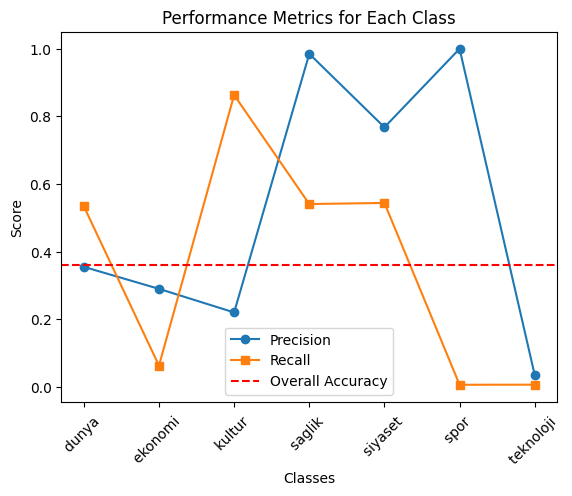

In [17]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Compute precision, recall, and F1-score for each class
precision, recall, _, _ = precision_recall_fscore_support(true_labels_original, predicted_labels_original, average=None)

# Compute overall accuracy
accuracy = accuracy_score(true_labels_original, predicted_labels_original)

# Create a line plot
classes = label_encoder.classes_
x = np.arange(len(classes))

plt.plot(x, precision, label='Precision', marker='o')
plt.plot(x, recall, label='Recall', marker='s')
plt.axhline(y=accuracy, color='r', linestyle='--', label='Overall Accuracy')

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Performance Metrics for Each Class')
plt.xticks(x, classes, rotation=45)
plt.legend()
plt.show()


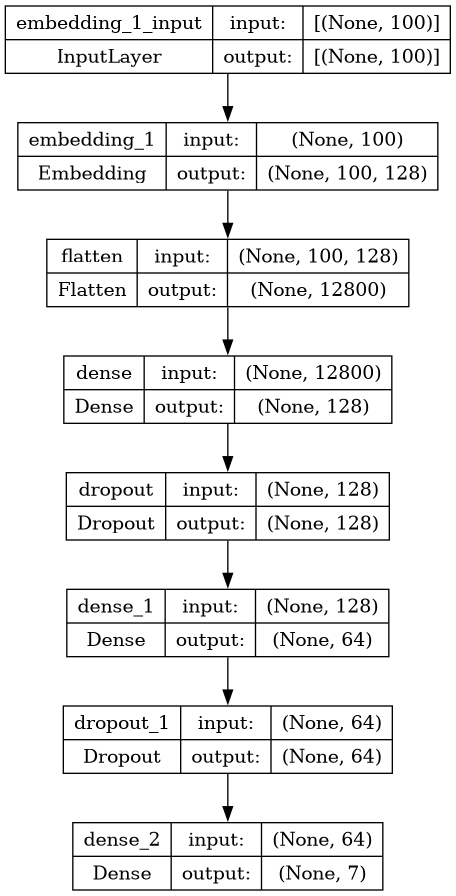

In [19]:
from tensorflow.keras.utils import plot_model

# Plot the model
plot_model(model_ann, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Display the plot
from IPython.display import Image
Image(filename='model_plot.png')


Epoch 1/10
123/123 [==============================] - 2s 13ms/step - loss: 1.5599 - accuracy: 0.3230 - val_loss: 1.5117 - val_accuracy: 0.3673
Epoch 2/10
123/123 [==============================] - 2s 13ms/step - loss: 1.5532 - accuracy: 0.3232 - val_loss: 1.5034 - val_accuracy: 0.4020
Epoch 3/10
123/123 [==============================] - 2s 12ms/step - loss: 1.5264 - accuracy: 0.3383 - val_loss: 1.5258 - val_accuracy: 0.3765
Epoch 4/10
123/123 [==============================] - 2s 12ms/step - loss: 1.5320 - accuracy: 0.3309 - val_loss: 1.5194 - val_accuracy: 0.3857
Epoch 5/10
123/123 [==============================] - 2s 13ms/step - loss: 1.5259 - accuracy: 0.3372 - val_loss: 1.5293 - val_accuracy: 0.3969
Epoch 6/10
123/123 [==============================] - 2s 14ms/step - loss: 1.4946 - accuracy: 0.3485 - val_loss: 1.5602 - val_accuracy: 0.3633
Epoch 7/10
123/123 [==============================] - 2s 12ms/step - loss: 1.5009 - accuracy: 0.3434 - val_loss: 1.5558 - val_accuracy: 0.3612

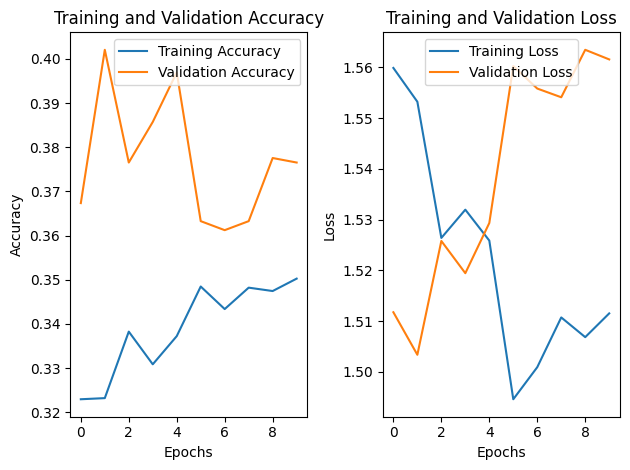

31/31 [==============================] - 0s 5ms/step - loss: 1.5616 - accuracy: 0.3765
Test Accuracy: 0.37653061747550964


In [20]:
import matplotlib.pyplot as plt


# Train your model and collect the training history
history = model_ann.fit(train_padded_word2vec, train_labels_encoded, epochs=10, validation_data=(test_padded_word2vec, test_labels_encoded))

# Plot the training and validation accuracy over epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot the training and validation loss over epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

# Evaluate your model
test_loss, test_acc = model_ann.evaluate(test_padded_word2vec, test_labels_encoded)
print(f'Test Accuracy: {test_acc}')


Epoch 1/10
123/123 [==============================] - 2s 12ms/step - loss: 1.4320 - accuracy: 0.3855 - val_loss: 1.6506 - val_accuracy: 0.3510
Epoch 2/10
123/123 [==============================] - 2s 12ms/step - loss: 1.4363 - accuracy: 0.3878 - val_loss: 1.6140 - val_accuracy: 0.3663
Epoch 3/10
123/123 [==============================] - 2s 12ms/step - loss: 1.4240 - accuracy: 0.3977 - val_loss: 1.7312 - val_accuracy: 0.3704
Epoch 4/10
123/123 [==============================] - 2s 12ms/step - loss: 1.4177 - accuracy: 0.3832 - val_loss: 1.6971 - val_accuracy: 0.3724
Epoch 5/10
123/123 [==============================] - 1s 12ms/step - loss: 1.4372 - accuracy: 0.3834 - val_loss: 1.6569 - val_accuracy: 0.3388
Epoch 6/10
123/123 [==============================] - 1s 12ms/step - loss: 1.4484 - accuracy: 0.3814 - val_loss: 1.6391 - val_accuracy: 0.3704
Epoch 7/10
123/123 [==============================] - 2s 12ms/step - loss: 1.4363 - accuracy: 0.3855 - val_loss: 1.6572 - val_accuracy: 0.3561

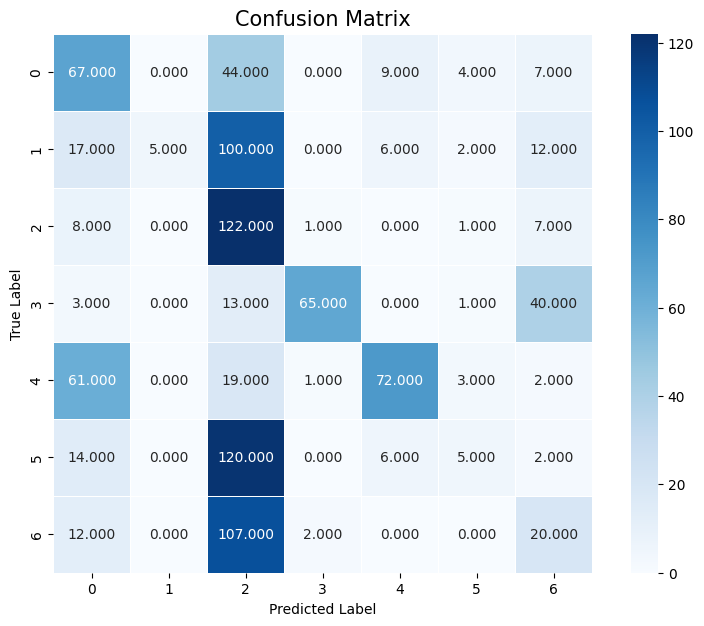

              precision    recall  f1-score   support

           0       0.37      0.51      0.43       131
           1       1.00      0.04      0.07       142
           2       0.23      0.88      0.37       139
           3       0.94      0.53      0.68       122
           4       0.77      0.46      0.57       158
           5       0.31      0.03      0.06       147
           6       0.22      0.14      0.17       141

    accuracy                           0.36       980
   macro avg       0.55      0.37      0.34       980
weighted avg       0.55      0.36      0.33       980



In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


# Train your model
model_ann.fit(train_padded_word2vec, train_labels_encoded, epochs=10, validation_data=(test_padded_word2vec, test_labels_encoded))

# Evaluate your model
test_loss, test_acc = model_ann.evaluate(test_padded_word2vec, test_labels_encoded)
print(f'Test Accuracy: {test_acc}')

# Generate predictions
predictions = model_ann.predict(test_padded_word2vec)
predicted_classes = np.argmax(predictions, axis=1)

# Confusion Matrix
cm = confusion_matrix(test_labels_encoded, predicted_classes)

# Visualize Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix', size=15)
plt.show()

# Classification Report
print(classification_report(test_labels_encoded, predicted_classes))


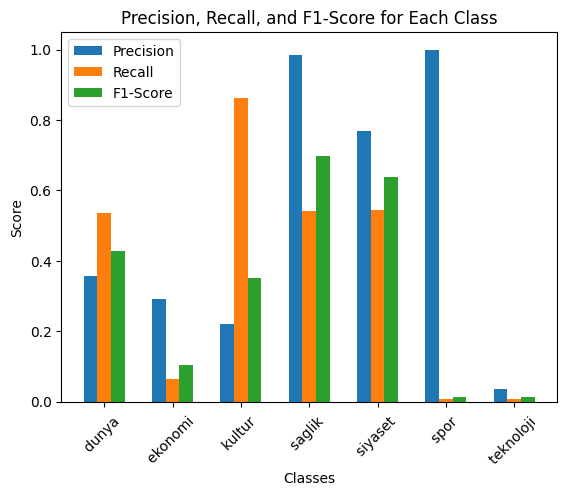

In [25]:
from sklearn.metrics import precision_recall_fscore_support

# Compute precision, recall, and F1-score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels_original, predicted_labels_original, average=None)

# Create a bar plot
classes = label_encoder.classes_
width = 0.2
x = np.arange(len(classes))

plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1-Score')

plt.xlabel('Classes')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.xticks(x, classes, rotation=45)
plt.legend()
plt.show()
